# 지지와 저항 지표

In [10]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import numpy as np

In [4]:

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620) # 주식 분할의 복잡성을 피하고자 분할이 없는 데이터만 취급. 따라서 620일
lows=goog_data['Low']
highs=goog_data['High']



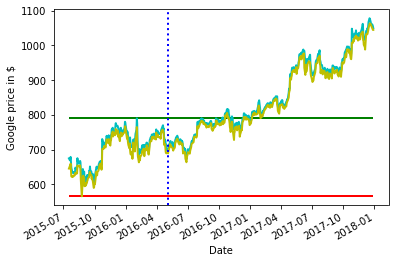

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0], lows.index.values[-1], linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0], lows.index.values[-1], linewidth=2, color='r')
plt.axvline(linewidth=2, color='b', x=lows.index.values[200], linestyle=':') 
plt.show()

- 녹색선 : 저항선
- 적색선 : 지지선

In [13]:

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
  print('File data found...reading GOOG data')
except FileNotFoundError:
  print('File not found...downloading the GOOG data')  
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']

def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x +1]
        support_level=min(data_section['price'])
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level            # 저항과 지지선은 최대와 최소 가격에서 20%의 마진 빼고 더해 계산
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
        
        if data['price'][x]>=data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        if in_resistance>2:
            data['signal'][x]=1
        elif in_support>2:
            data['signal'][x] = 0
        else:
            data['signal'][x] = data['signal'][x-1]
        
    data['positions'] = data['signal'].diff()                                 # diff를 사용해 주문 시기 파악

trading_support_resistance(goog_data_signal)
        
# 2일 연속 저항선의 허용 마진에 머물 때 매수 주문, 2일 연속 지지선의 허용 마진에 머물 때 매도 주문            
        


File data found...reading GOOG data


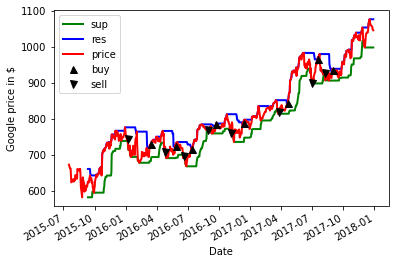

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
        goog_data_signal.price[goog_data_signal.positions == 1.0],
        '^', markersize=7, color='k', label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
        goog_data_signal.price[goog_data_signal.positions == -1.0],
        'v', markersize=7, color='k', label='sell')
plt.legend()
plt.show()